# Yelp Data Temporal Trends

In [1]:
# Modules
import pandas as pd
import math
import numpy as np
import scipy as sp
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import os
import sys
import pytz
from datetime import datetime
from time import gmtime, strftime
import io
import smtplib, ssl

import glob
import zipfile
import gzip
import shutil
import re
import json
from json import JSONDecoder, JSONDecodeError
#from pandas.io.json import json_normalize
from collections import defaultdict

import boto3
from botocore.exceptions import NoCredentialsError
from boto.s3.connection import S3Connection
from boto.glacier.layer1 import Layer1
from boto.glacier.concurrent import ConcurrentUploader

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

%matplotlib inline

## Program Parameters

In [3]:
# Constants
MASTER_DATE_FORMAT = '%Y%m%d'

# CDH access parameters
CDH_ACCESS_KEY_ID = "REDACTED"
CDH_SECRET_ACCESS_KEY = "REDACTED"
CDH_REGION = "us-east-2"

CDH_BUCKET_AUX = 'yelp-auxiliary-files'
CDH_BUCKET_MASTER = 'yelp-master-files'

In [5]:
# Paths
PROJECT_PATH = '/Users/arthurpelullo/Desktop/career/portfolio/public_portfolio/yelp_health_data_curation_ops/'

DATA_PATH = PROJECT_PATH + 'data/'
OUTPUT_PATH = PROJECT_PATH + 'output/'

DATA_SUMMARY_PATH = DATA_PATH + 'summary/'

In [7]:
# Lists and dictionaries
month_dict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
              7:'July',8:'August',9:'September',10:'October',11:'November',12:'December',}
kinds = ['categories','facilities','reviews']

## Function Definitions

In [10]:
def get_date_str(date, formatted=False):
    year = str(date.year)
    month = str(date.month)
    if len(month)==1:
        month = '0'+month
    day = str(date.day)
    if len(day)==1:
        day = '0'+day
        
    if formatted:
        date = year+'/'+month+'/'+day
    else:
        date = year+month+day
    return date

## Extract Data From AWS

In [13]:
# Connect to aws resources
s3_cdh = boto3.client('s3', aws_access_key_id=CDH_ACCESS_KEY_ID, aws_secret_access_key=CDH_SECRET_ACCESS_KEY, region_name=CDH_REGION)

In [35]:
# Get dates for last week
current_date = pd.to_datetime(datetime.now().date()).date()

start_date = current_date - pd.to_timedelta(8,unit='days')
end_date = current_date - pd.to_timedelta(1,unit='days')
dates = [get_date_str(start_date),get_date_str(end_date)]

In [37]:
# Get daily data summary for last week
try:
    name = get_date_str(current_date) + '_daily_data.csv'
    daily_data = s3_cdh.get_object(Bucket=CDH_BUCKET_AUX, Key=name)
except:
    print('Data not available for',current_date,'Using previous day.')
    current_date = current_date - pd.to_timedelta(1,unit='days')
    name = get_date_str(current_date) + '_daily_data.csv'
    daily_data = s3_cdh.get_object(Bucket=CDH_BUCKET_AUX, Key=name)
    
daily_data = pd.read_csv(io.BytesIO(daily_data['Body'].read()), index_col=0)

# Adjust columns and extract weekly data
formatted_dates = [datetime.strptime(str(item), MASTER_DATE_FORMAT).date() for item in daily_data.date]
daily_data['formatted_date'] = formatted_dates
daily_data['date'] = daily_data['date'].astype('str')
weekly_df = daily_data[daily_data['date'].isin(dates)]

In [39]:
# Draft weekly update email
start_date_str = get_date_str(start_date, formatted=True)
end_date_str = get_date_str(end_date, formatted=True)

print('A summary of changes in the Yelp data between' + 
      '\033[1m',start_date_str,'\033[0m' + 'and' +'\033[1m',end_date_str,'\033[0m' +
      'is presented below:')
print()

start_count = weekly_df['fac_count'].iloc[0]
end_count = weekly_df['fac_count'].iloc[1]
print('\033[1mFacilities:\033[0m')
print('Facility count on ' + start_date_str + ': ' + str(start_count))
print('Facility count on ' + end_date_str + ': ' + str(end_count))
print('Difference:', str(end_count-start_count))
print()

start_count = weekly_df['rev_count'].iloc[0]
end_count = weekly_df['rev_count'].iloc[1]
print('\033[1mReviews:\033[0m')
print('Review count on ' + start_date_str + ': ' + str(start_count))
print('Review count on ' + end_date_str + ': ' + str(end_count))
print('Difference:', str(end_count-start_count))
print()

start_count = weekly_df['cat_count'].iloc[0]
end_count = weekly_df['cat_count'].iloc[1]
print('\033[1mCategories:\033[0m')
print('Category count on ' + start_date_str + ': ' + str(start_count))
print('Category count on ' + end_date_str + ': ' + str(end_count))
print('Difference:', str(end_count-start_count))
print()

print('Thanks!\nArt')

A summary of changes in the Yelp data between 2024/07/27 and 2024/08/03 is presented below:

Facilities:
Facility count on 2024/07/27: 667722
Facility count on 2024/08/03: 670213
Difference: 2491

Reviews:
Review count on 2024/07/27: 7806299
Review count on 2024/08/03: 7841559
Difference: 35260

Categories:
Category count on 2024/07/27: 739
Category count on 2024/08/03: 742
Difference: 3

Thanks!
Art


Facility count on 04/30/2019: 469551
Facility count on 01/16/2020: 670543
Difference: 200992


[None, None, None, None, None, None, None, None, None, None, None]

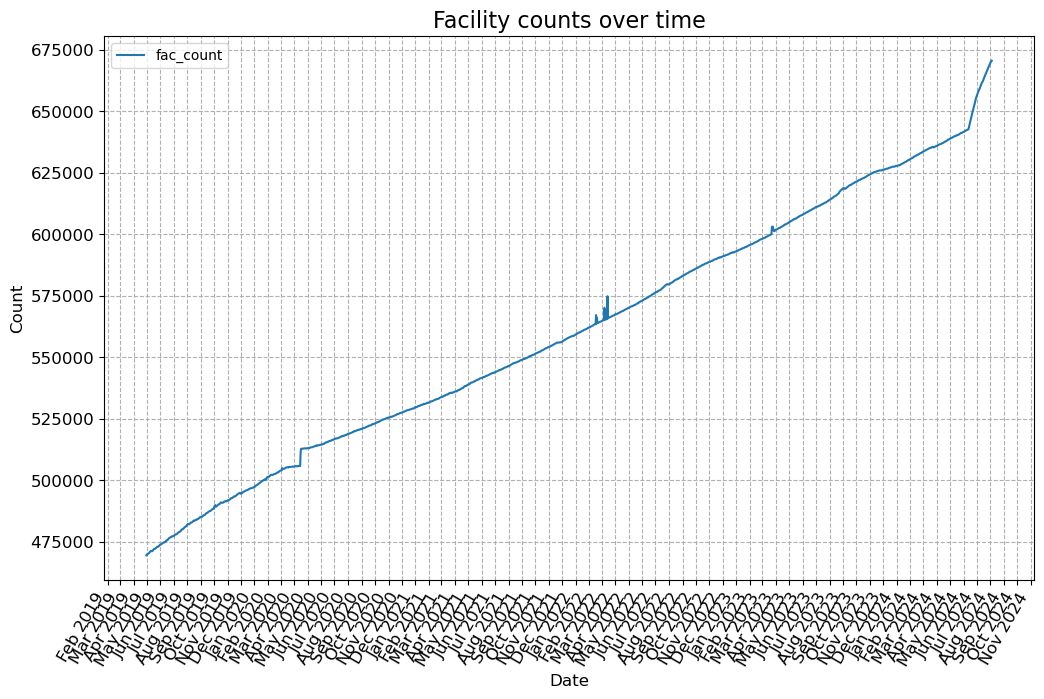

In [41]:
# Facilities
plot_data = daily_data.copy()
plot_data = plot_data.reset_index(drop=True)
plot_data.date = pd.to_datetime(plot_data.date.astype('str'))

ax = plot_data.plot(x='date',y='fac_count',figsize=(12,8))
plt.grid(True, linestyle='--')
ax.set_title('Facility counts over time', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
print('Facility count on 04/30/2019:',daily_data.iloc[0].fac_count)
print('Facility count on 01/16/2020:',daily_data.iloc[-1].fac_count)
print('Difference:',daily_data.iloc[-1].fac_count-daily_data.iloc[0].fac_count)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

Review count on 04/30/2019: 3945991
Review count on 01/16/2020: 7845941
Difference: 3899950


[None, None, None, None, None, None, None, None, None, None, None]

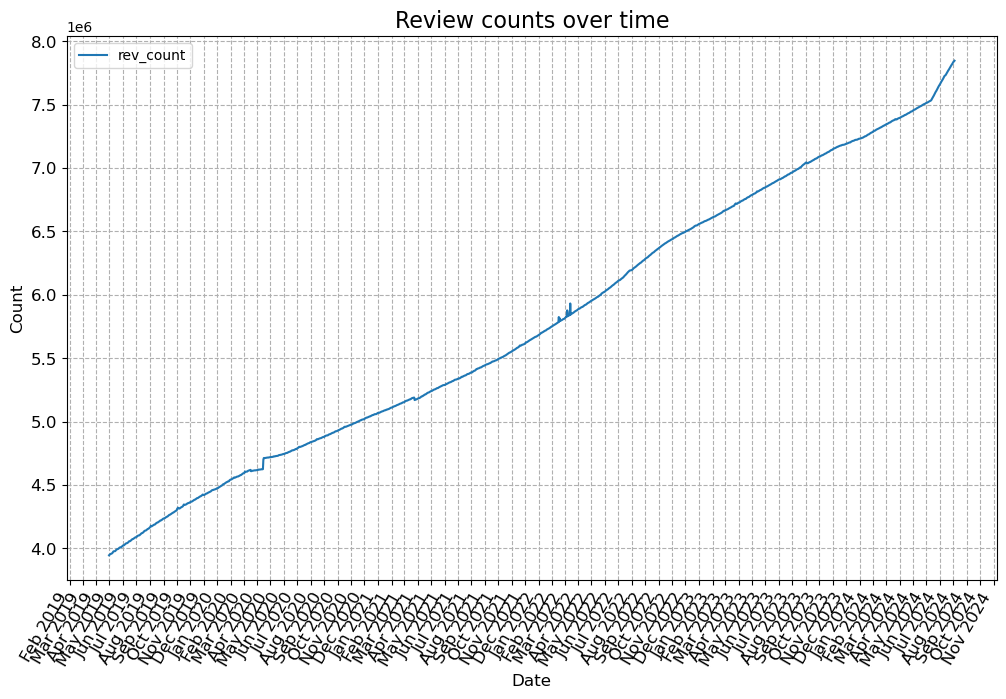

In [43]:
# Reviews
plot_data = daily_data.copy()
plot_data = plot_data.reset_index(drop=True)
plot_data.date = pd.to_datetime(plot_data.date.astype('str'))


ax = plot_data.plot(x='date',y='rev_count',figsize=(12,8))
plt.grid(True, linestyle='--')
ax.set_title('Review counts over time', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
print('Review count on 04/30/2019:',daily_data.iloc[0].rev_count)
print('Review count on 01/16/2020:',daily_data.iloc[-1].rev_count)
print('Difference:',daily_data.iloc[-1].rev_count-daily_data.iloc[0].rev_count)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

In [29]:
print('Collection Period:',len(daily_data),'days')
print('Summary Stats:',len(daily_data.columns),'columns')
daily_data.head()

Collection Period: 1788 days
Summary Stats: 11 columns


,cat_count,date,fac_count,fac_rating_mean,fac_rating_med,fac_rev_count_mean,fac_rev_count_med,rev_count,rev_rating_mean,rev_rating_med,formatted_date
0,658,20190430,469551,3.7519,4.0,8.4034,3.0,3945991,3.8443,5.0,2019-04-30
1,657,20190501,469689,3.7522,4.0,8.4085,3.0,3949522,3.8446,5.0,2019-05-01
2,657,20190502,469961,3.7523,4.0,8.4103,3.0,3952748,3.8448,5.0,2019-05-02
3,659,20190503,470078,3.7527,4.0,8.4141,3.0,3955474,3.8449,5.0,2019-05-03
4,659,20190504,470215,3.7527,4.0,8.4155,3.0,3957267,3.8448,5.0,2019-05-04


In [17]:
save_name = DATA_SUMMARY_PATH + 'daily_yelp_summary_20190430_' + str(datetime.now().date()).replace('-','') + '.csv'
daily_data.to_csv(save_name)

In [31]:
daily_data.tail()

,cat_count,date,fac_count,fac_rating_mean,fac_rating_med,fac_rev_count_mean,fac_rev_count_med,rev_count,rev_rating_mean,rev_rating_med,formatted_date
0,741,20240817,674178,3.7086,4.0,11.7292,3.0,7908875,3.7598,5.0,2024-08-17
0,741,20240818,674240,3.7085,4.0,11.7326,3.0,7911862,3.7598,5.0,2024-08-18
0,741,20240819,674296,3.7085,4.0,11.7358,3.0,7914663,3.7596,5.0,2024-08-19
0,741,20240820,674478,3.7083,4.0,11.7414,3.0,7920569,3.7592,5.0,2024-08-20
0,740,20240821,674637,3.7082,4.0,11.7448,3.0,7924785,3.7591,5.0,2024-08-21


## Unused / Deprecated Code

In [19]:
"""

def get_daily(amt,days,sched=None):
    if sched != None:
        pass
    
    daily_int = amt // days
    daily_rem = (amt % days)/days
    daily = daily_int + daily_rem
    
    return daily
    

daily_data = pd.read_csv(DATA_SUMMARY_PATH + 'daily_data_01162020.csv', index_col=0)

# Adjust columns
formatted_dates = [datetime.strptime(str(item), MASTER_DATE_FORMAT).date() for item in daily_data.date]
daily_data['formatted_date'] = formatted_dates


ax = daily_data.cat_count.plot(title='Category counts over time')
ax.set_xlabel('Day')
ax.set_ylabel('Count')
print('Category count on 04/30/2019:',daily_data.iloc[0].cat_count)
print('Category count on 01/16/2020:',daily_data.iloc[-1].cat_count)
print('Difference:',daily_data.iloc[-1].cat_count-daily_data.iloc[0].cat_count)


ax = daily_data.fac_count.plot(title='Facility counts over time')
ax.set_xlabel('Day')
ax.set_ylabel('Count')
print('Facility count on 04/30/2019:',daily_data.iloc[0].fac_count)
print('Facility count on 01/16/2020:',daily_data.iloc[-1].fac_count)
print('Difference:',daily_data.iloc[-1].fac_count-daily_data.iloc[0].fac_count)


ax = daily_data.rev_count.plot(title='Review counts over time')
ax.set_xlabel('Day')
ax.set_ylabel('Count')
print('Review count on 04/30/2019:',daily_data.iloc[0].rev_count)
print('Review count on 01/16/2020:',daily_data.iloc[-1].rev_count)
print('Difference:',daily_data.iloc[-1].rev_count-daily_data.iloc[0].rev_count)

"""

"\n\ndef get_daily(amt,days,sched=None):\n    if sched != None:\n        pass\n    \n    daily_int = amt // days\n    daily_rem = (amt % days)/days\n    daily = daily_int + daily_rem\n    \n    return daily\n    \n\ndaily_data = pd.read_csv(DATA_SUMMARY_PATH + 'daily_data_01162020.csv', index_col=0)\n\n# Adjust columns\nformatted_dates = [datetime.strptime(str(item), MASTER_DATE_FORMAT).date() for item in daily_data.date]\ndaily_data['formatted_date'] = formatted_dates\n\n\nax = daily_data.cat_count.plot(title='Category counts over time')\nax.set_xlabel('Day')\nax.set_ylabel('Count')\nprint('Category count on 04/30/2019:',daily_data.iloc[0].cat_count)\nprint('Category count on 01/16/2020:',daily_data.iloc[-1].cat_count)\nprint('Difference:',daily_data.iloc[-1].cat_count-daily_data.iloc[0].cat_count)\n\n\nax = daily_data.fac_count.plot(title='Facility counts over time')\nax.set_xlabel('Day')\nax.set_ylabel('Count')\nprint('Facility count on 04/30/2019:',daily_data.iloc[0].fac_count)\npr

In [20]:
"""
### Facility review trends

daily_data[['fac_rev_count_mean']].plot()

daily_data[['fac_rev_rating_mean']].plot()

### Review rating trends

daily_data[['rev_rating_mean']].plot()
"""

"\n### Facility review trends\n\ndaily_data[['fac_rev_count_mean']].plot()\n\ndaily_data[['fac_rev_rating_mean']].plot()\n\n### Review rating trends\n\ndaily_data[['rev_rating_mean']].plot()\n"

In [21]:
"""
#DONEDONEDONE
daily_data = s3_cdh.get_object(Bucket=CDH_BUCKET_AUX, Key='daily_summary_data.csv')
daily_data_df = pd.read_csv(io.BytesIO(daily_data['Body'].read()), index_col=0)


keys = [item['Key'] for item in s3_cdh.list_objects(Bucket='yelp-master-files')['Contents'] if int(item['Key'].split('_')[0]) > 20200116]
categories = []
facilities = []
reviews = []
count = 0

for key in keys:
    print('Processing file', key)
    date=key.split('_')[0]
    kind=key.split('_')[-1].split('.')[0]
    file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)
    file_df = pd.read_csv(io.BytesIO(file_obj['Body'].read()))

    if kind == 'categories':
        categories.append([date, len(file_df.alias.unique())])
    if kind == 'facilities':
        facilities.append([date, len(file_df), 
                           file_df['fac_rating'].mean(), file_df['fac_rating'].median(),
                           file_df['review_count'].mean(),file_df['review_count'].median()])
    if kind == 'reviews':
        reviews.append([date, len(file_df),
                        file_df['rev_rating'].mean(), file_df['rev_rating'].median()])

    count +=1
    print('File', key, 'processed.')
    print(count, 'files processed...')
    del file_df

# Save data in dataframes
cat_df = pd.DataFrame(categories,columns=['date','cat_count'])
fac_df = pd.DataFrame(facilities,columns=['date','fac_count',
                                          'fac_rating_mean','fac_rating_med',
                                          'fac_rev_count_mean','fac_rev_count_med'])
rev_df = pd.DataFrame(reviews,columns=['date','rev_count','rev_rating_mean','rev_rating_med'])
weekly_df = cat_df.merge(fac_df, on='date',how='inner').merge(rev_df, on='date',how='inner')



daily_data_df = daily_data_df.rename(columns={'fac_rev_rating_mean':'fac_rating_mean','fac_rev_rating_med':'fac_rating_med'})
data = pd.concat([daily_data_df, weekly_df])
data.to_csv(SUMMARY_PATH + 'daily_data.csv')



# Summary files: standard
for file in glob.glob(SUMMARY_PATH + '*.csv'):
    local_file_name = file
    aws_file_name = file.split(SUMMARY_PATH)[-1]
    bucket_name = CDH_BUCKET_AUX

    args_dict=dict()
    args_dict['StorageClass']='STANDARD'

    uploaded = upload_to_aws(local_file_name, bucket_name, aws_file_name, args_dict)
    if uploaded:
        os.remove(file)
    else:
        print('File ', file, ' not uploaded!')

"""

"\n#DONEDONEDONE\ndaily_data = s3_cdh.get_object(Bucket=CDH_BUCKET_AUX, Key='daily_summary_data.csv')\ndaily_data_df = pd.read_csv(io.BytesIO(daily_data['Body'].read()), index_col=0)\n\n\nkeys = [item['Key'] for item in s3_cdh.list_objects(Bucket='yelp-master-files')['Contents'] if int(item['Key'].split('_')[0]) > 20200116]\ncategories = []\nfacilities = []\nreviews = []\ncount = 0\n\nfor key in keys:\n    print('Processing file', key)\n    date=key.split('_')[0]\n    kind=key.split('_')[-1].split('.')[0]\n    file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)\n    file_df = pd.read_csv(io.BytesIO(file_obj['Body'].read()))\n\n    if kind == 'categories':\n        categories.append([date, len(file_df.alias.unique())])\n    if kind == 'facilities':\n        facilities.append([date, len(file_df), \n                           file_df['fac_rating'].mean(), file_df['fac_rating'].median(),\n                           file_df['review_count'].mean(),file_df['review_count'].median()

In [22]:
"""
# Connect to AWS resource
s3_cdh = boto3.client('s3', aws_access_key_id=CDH_ACCESS_KEY_ID, aws_secret_access_key=CDH_SECRET_ACCESS_KEY, region_name=CDH_REGION)

# Weekly updates on Mondays
current_date = pd.to_datetime(datetime.now().date()).date()
if current_date.weekday() == 0:
    categories = []
    facilities = []
    reviews = []
    count = 0
    
    # Get dates
    start_date = current_date - pd.to_timedelta(7,unit='days')
    start_date_string = get_date_string(start_date)
    end_date = current_date - pd.to_timedelta(1,unit='days')
    end_date_string = get_date_string(end_date)
    dates = [start_date_string,end_date_string]
    
    # Get summary data
    keys = [date+'_'+kind+'.csv' for date in dates for kind in kinds]
    for key in keys:
        print('Processing file', key)
        date=key.split('_')[0]
        kind=key.split('_')[-1].split('.')[0]
        file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)
        file_df = pd.read_csv(io.BytesIO(file_obj['Body'].read()))
        
        if kind == 'categories':
            categories.append([date, len(file_df.alias.unique())])
        if kind == 'facilities':
            facilities.append([date, len(file_df), 
                               file_df['fac_rating'].mean(), file_df['fac_rating'].median(),
                               file_df['review_count'].mean(),file_df['review_count'].median()])
        if kind == 'reviews':
            reviews.append([date, len(file_df),
                            file_df['rev_rating'].mean(), file_df['rev_rating'].median()])

        count +=1
        print('File', key, 'processed.')
        print(count, 'files processed...')
        del file_df
    
    # Save data in dataframes
    cat_df = pd.DataFrame(categories,columns=['date','cat_count'])
    fac_df = pd.DataFrame(facilities,columns=['date','fac_count',
                                              'fac_rating_mean','fac_rating_med',
                                              'fac_rev_count_mean','fac_rev_count_med'])
    rev_df = pd.DataFrame(reviews,columns=['date','rev_count','rev_rating_mean','rev_rating_med'])
    weekly_df = cat_df.merge(fac_df, on='date',how='inner').merge(rev_df, on='date',how='inner')
    
"""

"\n# Connect to AWS resource\ns3_cdh = boto3.client('s3', aws_access_key_id=CDH_ACCESS_KEY_ID, aws_secret_access_key=CDH_SECRET_ACCESS_KEY, region_name=CDH_REGION)\n\n# Weekly updates on Mondays\ncurrent_date = pd.to_datetime(datetime.now().date()).date()\nif current_date.weekday() == 0:\n    categories = []\n    facilities = []\n    reviews = []\n    count = 0\n    \n    # Get dates\n    start_date = current_date - pd.to_timedelta(7,unit='days')\n    start_date_string = get_date_string(start_date)\n    end_date = current_date - pd.to_timedelta(1,unit='days')\n    end_date_string = get_date_string(end_date)\n    dates = [start_date_string,end_date_string]\n    \n    # Get summary data\n    keys = [date+'_'+kind+'.csv' for date in dates for kind in kinds]\n    for key in keys:\n        print('Processing file', key)\n        date=key.split('_')[0]\n        kind=key.split('_')[-1].split('.')[0]\n        file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)\n        file_df = pd.

In [23]:
"""
keys = [item['Key'] for item in s3_cdh.list_objects(Bucket='yelp-master-files')['Contents'] if int(item['Key'].split('_')[0]) > 20200116]
for key in keys:
    print('Processing file', key)
    date=key.split('_')[0]
    kind=key.split('_')[-1].split('.')[0]
    file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)
    file_df = pd.read_csv(io.BytesIO(file_obj['Body'].read()))

    if kind == 'categories':
        categories.append([date, len(file_df.alias.unique())])
    if kind == 'facilities':
        facilities.append([date, len(file_df), 
                           file_df['fac_rating'].mean(), file_df['fac_rating'].median(),
                           file_df['review_count'].mean(),file_df['review_count'].median()])
    if kind == 'reviews':
        reviews.append([date, len(file_df),
                        file_df['rev_rating'].mean(), file_df['rev_rating'].median()])

    count +=1
    print('File', key, 'processed.')
    print(count, 'files processed...')
    del file_df

# Save data in dataframes
cat_df = pd.DataFrame(categories,columns=['date','cat_count'])
fac_df = pd.DataFrame(facilities,columns=['date','fac_count',
                                          'fac_rating_mean','fac_rating_med',
                                          'fac_rev_count_mean','fac_rev_count_med'])
rev_df = pd.DataFrame(reviews,columns=['date','rev_count','rev_rating_mean','rev_rating_med'])
weekly_df = cat_df.merge(fac_df, on='date',how='inner').merge(rev_df, on='date',how='inner')

"""

"\nkeys = [item['Key'] for item in s3_cdh.list_objects(Bucket='yelp-master-files')['Contents'] if int(item['Key'].split('_')[0]) > 20200116]\nfor key in keys:\n    print('Processing file', key)\n    date=key.split('_')[0]\n    kind=key.split('_')[-1].split('.')[0]\n    file_obj = s3_cdh.get_object(Bucket=CDH_BUCKET_MASTER, Key=key)\n    file_df = pd.read_csv(io.BytesIO(file_obj['Body'].read()))\n\n    if kind == 'categories':\n        categories.append([date, len(file_df.alias.unique())])\n    if kind == 'facilities':\n        facilities.append([date, len(file_df), \n                           file_df['fac_rating'].mean(), file_df['fac_rating'].median(),\n                           file_df['review_count'].mean(),file_df['review_count'].median()])\n    if kind == 'reviews':\n        reviews.append([date, len(file_df),\n                        file_df['rev_rating'].mean(), file_df['rev_rating'].median()])\n\n    count +=1\n    print('File', key, 'processed.')\n    print(count, 'files pro